In [7]:
import pandas as pd
import numpy as np
from nptdms import TdmsFile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import control as ctrl

# Path to the directory containing TDMS files
tdms_dir = r'C:\Users\patry\OneDrive\Pulpit\testv2'

# List to store paths of TDMS files
tdms_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(tdms_dir):
    print(f"There are {len(dirs)} directories and {len(files)} file in {root}")
    
    for file in files:
        if file.endswith(".tdms"):
            # If the file ends with '.tdms', add its full path to the list
            tdms_list.append(os.path.join(root, file))
    

There are 0 directories and 1 file in C:\Users\patry\OneDrive\Pulpit\testv2


In [8]:
# Create an empty list to store data
data_list = []

# Open tdms files and create a list with labels
for tdms_file_path in tdms_list:
    tdms_file = TdmsFile.read(tdms_file_path)
    first_letter = os.path.basename(tdms_file_path)[0]
    
    for group in tdms_file.groups():
        for channel in group.channels():
            data_len = np.shape(channel.data)[0]
            # Check conditions and append data to list
            if (data_len <= 1000000 and data_len >= 10000 and first_letter != 'z'):
                data_list.append({
                    #'anchor_ids': group.name,
                    'class': first_letter,
                    #'driveway': channel.name,
                    'excitation': channel.data,
                    'type_id': 1 if first_letter == 'd' else 0
                })

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

In [9]:
print(df.head()) # here we cvan see that even index have date and time but odd have amplitude

  class                                         excitation  type_id
0     D  [0.6866276880000015, 0.3075305780000015, -0.42...        0
1     D  [-0.49908613000000024, 1.0268593800000012, 0.8...        0
2     D  [0.06955953500000156, 0.5646157610000007, 0.33...        0
3     D  [0.3049820260000011, 0.14633466400000117, 0.52...        0
4     D  [-0.20440980499999917, 0.14506038800000098, 0....        0


In [10]:
df_date = df.loc[df.index % 2 == 0]
df_magitude = df.loc[df.index % 2 != 0]

760000
380000
760000
380000
760000
380000
760000
380000


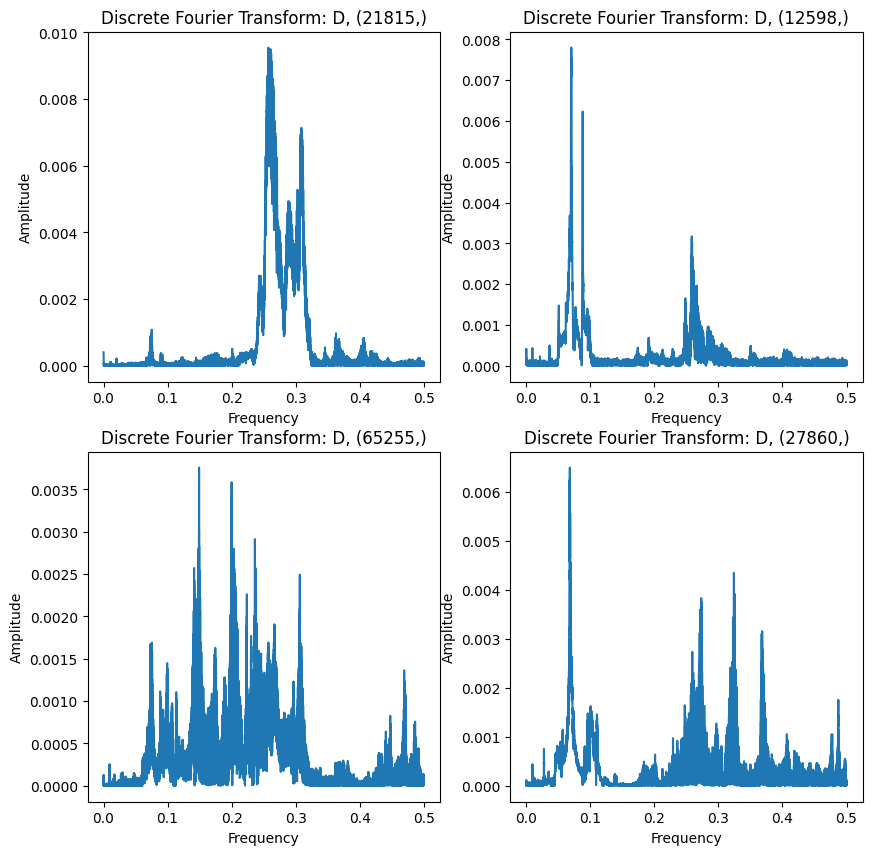

In [11]:
import DFT 
import matplotlib.pyplot as plt

# Plot some DFT
rows, cols = 2, 2
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Find the longest signal length
longest = max(len(signal) for signal in df_magitude['excitation'])

for ax in axs.flatten():
    random_idx = np.random.randint(0, len(df_magitude['excitation']))
    signal = df_magitude['excitation'].iloc[random_idx]
    
    # Pad the signal to match the longest length
    padded = np.pad(signal, (0, longest - np.shape(signal)[0]), mode="constant", constant_values=0)
    print(len(padded))
    length = np.linspace(0, len(padded), len(padded))
    DFT_transform = DFT.SpectralAnalysis(time=length,
                                         amplitude=padded,
                                         dt=1)    # do dopytania 
    frequencies, amplitudes = DFT_transform.DFT_transform()
    print(len(frequencies))
    ax.plot(frequencies, amplitudes)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title(f"Discrete Fourier Transform: {df_magitude['class'].iloc[random_idx]}, {signal.shape}")

In [12]:
def cosinus_to_tf(amplitude: float, frequency: float):
    if frequency == 0:
        L_o = ([round(amplitude, 6)])
        M_o = ([1, 0])
    else:
        L_o = ([1, 0])
        M_o = ([1, 0, round(2*np.pi*frequency, 6)**2])

    return L_o, M_o

def fourier_to_laplace(signal: np.array,
                       number_harmonic: int,
                       step: int,
                       dt: float = 0.1) -> ctrl.tf:
    """
    Function transform data to Fourier tranform and next with step take the harmonic a with 
    this take a amplitude and frequensy and crete laplace tranform from this signal
    @param signal: Array with magnitudes of the signal
    @param number_harmonic: how many functions are added to create the Laplace transform
    @param step: step to look for the most valued harmonic
    @param dt: time step which we have measured in signal
    @return: Laplace transform of the signal
    """
    # Compute the Fourier transform
    frequencies, amplitudes = np.fft.fftfreq(len(signal), d=dt), np.fft.fft(signal)

    # Exclude the smallest frequency value
    min_freq_index = np.argmin(np.abs(frequencies))
    frequencies = np.delete(frequencies, min_freq_index)
    amplitudes = np.delete(amplitudes, min_freq_index)

    # Initialize a list to store transfer functions for each harmonic
    tf_o_list = []

    # Sort indices based on amplitude magnitude
    sorted_indices = np.argsort(np.abs(amplitudes))[::-1]

    # Iterate over the most significant harmonics
    for i in range(number_harmonic):
        # Calculate index based on sorted indices and step
        index = sorted_indices[i * step]

        # Generate transfer function for the current harmonic
        L, M = cosinus_to_tf(amplitude=np.abs(amplitudes[index]), frequency=frequencies[index])
        tf_o_list.append(ctrl.TransferFunction(L, M))

    # Sum up all transfer functions
    tf_o_sum = tf_o_list[0]
    for tf in tf_o_list[1:]:
        tf_o_sum += tf

    # Create transfer function for the input signal (signal with the highest amplitude)
    max_amplitude_index = np.argmax(np.abs(amplitudes))
    L_i, M_i = cosinus_to_tf(amplitude=np.abs(amplitudes[max_amplitude_index]),
                             frequency=frequencies[max_amplitude_index])

    # Create the transfer function for the whole open loop system
    G_open = tf_o_sum / ctrl.TransferFunction(L_i, M_i)

    return G_open


In [13]:
from sklearn.preprocessing import MinMaxScaler


In [17]:
import numpy as np

data = []

for i in range(len(df_magitude['excitation'])):
    G_open = fourier_to_laplace(signal=df_magitude['excitation'].iloc[i], 
                                number_harmonic=10,
                                step=400,
                                dt=1)

    zeros = G_open.zero()
    poles = G_open.pole()

    # Extract zeros' real and imaginary parts
    zeros_real_image = [(z.real, z.imag) for z in zeros]
    
    # Extract poles' real and imaginary parts 
    poles_real_image = [(p.real, p.imag) for p in poles]
    
  
    # Calculate min and max for each column
    min_zero_real = min(z[0] for z in zeros_real_image)
    max_zero_real = max(z[0] for z in zeros_real_image)
    min_zero_imag = min(z[1] for z in zeros_real_image)
    max_zero_imag = max(z[1] for z in zeros_real_image)
    min_pole_real = min(p[0] for p in poles_real_image)
    max_pole_real = max(p[0] for p in poles_real_image)
    min_pole_imag = min(p[1] for p in poles_real_image)
    max_pole_imag = max(p[1] for p in poles_real_image)
    
    # Scale the real and imaginary parts of zeros and poles separately
    scaled_zeros_real = [(z[0] - min_zero_real) / (max_zero_real - min_zero_real) for z in zeros_real_image]
    scaled_zeros_imag = [(z[1] - min_zero_imag) / (max_zero_imag - min_zero_imag) for z in zeros_real_image]
    scaled_poles_real = [(p[0] - min_pole_real) / (max_pole_real - min_pole_real) for p in poles_real_image]
    scaled_poles_imag = [(p[1] - min_pole_imag) / (max_pole_imag - min_pole_imag) for p in poles_real_image]
    
    df_zer_poles_normal = {
        "zero_real": scaled_zeros_real,
        "zero_image": scaled_zeros_imag,
        "pole_real": scaled_poles_real,
        "pole_image": scaled_poles_imag,
        'type_id': df_magitude['type_id'].iloc[i]
    }
    
    data.append(df_zer_poles_normal)

# Create a dataframe
df = pd.DataFrame(data)


In [18]:
# split data od 2d and 1d dataframe
df_1d = pd.DataFrame()
df_1d['1d_array'] = df[['zero_real', 'zero_image', 'pole_real', 'pole_image']].apply(lambda x: [item for sublist in x for item in sublist], axis=1)
df_1d = pd.concat([df_1d, df['type_id']], axis=1)

df_2d = pd.DataFrame()
df_2d['2d_array'] = df[['zero_real', 'zero_image', 'pole_real', 'pole_image']].values.tolist()
df_2d = pd.concat([df_2d, df['type_id']], axis=1)

In [19]:
df_1d.head()

,1d_array,type_id
0,"[0.0, 0.0, 1.0, 1.0, 0.07894625552015706, 0.07...",0
1,"[0.46511627906976744, 0.46511627906976744, 0.2...",0
2,"[0.4953602268333548, 0.4953602268333548, 0.492...",0
3,"[0.43241575114183434, 0.43241575114183434, 0.4...",0
4,"[0.4521738171785922, 0.4521738171785922, 0.452...",0


In [20]:
df_2d.head()

,2d_array,type_id
0,"[[0.0, 0.0, 1.0, 1.0, 0.07894625552015706, 0.0...",0
1,"[[0.46511627906976744, 0.46511627906976744, 0....",0
2,"[[0.4953602268333548, 0.4953602268333548, 0.49...",0
3,"[[0.43241575114183434, 0.43241575114183434, 0....",0
4,"[[0.4521738171785922, 0.4521738171785922, 0.45...",0


In [21]:
# test
print(len(df_2d['2d_array'][0]))
print(len(df_1d['1d_array'][0]))

4
84


In [22]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [23]:
# device agnostice code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(df_1d['1d_array'].values.tolist(), 
                                                    df_1d['type_id'].values.tolist(), 
                                                    test_size=0.2, 
                                                    random_state=42)

In [25]:
X_test

[[0.5475413236125951,
  0.5475413236125951,
  0.5371208597825404,
  0.5371208597825404,
  0.5619068568914587,
  0.5619068568914587,
  0.5068292376343411,
  0.5068292376343411,
  0.6794959462007416,
  0.6794959462007416,
  0.0,
  0.0,
  1.0,
  1.0,
  0.5343787316950538,
  0.5343787316950538,
  0.5413500094274402,
  0.5413500094274402,
  0.5460360756709195,
  0.5460360756709195,
  0.5454635158066746,
  1.0,
  0.0,
  0.9873382205211856,
  0.012661779478814392,
  0.9706980122918516,
  0.0293019877081484,
  0.9475386120758473,
  0.05246138792415266,
  0.9298585743027953,
  0.07014142569720477,
  0.9205565576254334,
  0.07944344237456652,
  0.9187862772724155,
  0.08121372272758455,
  0.9115537898564406,
  0.0884462101435593,
  0.8997305016977271,
  0.10026949830227291,
  0.8893955496417262,
  0.11060445035827385,
  0.5,
  0.5265730646978389,
  0.5265730646978389,
  0.520115319446366,
  0.520115319446366,
  0.5328744872345433,
  0.5328744872345433,
  0.532562740211413,
  0.532562740211413,
 

In [26]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
Y_train = torch.tensor(Y_train)
Y_test = torch.tensor(Y_test)

In [27]:
#### Model (with onli linear layer)
class Zero_Pole_Model_Linear(nn.Module):
    def __init__(self, input_size, hidden_unit, classes_num):
        super(Zero_Pole_Model_Linear, self).__init__()
        self.input_size = input_size
        self.hidden_unit = hidden_unit

        self.block_1 = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_unit),
            nn.ReLU(),
            nn.Linear(self.hidden_unit, 100*self.hidden_unit),
            nn.ReLU(),
            nn.Linear(100*self.hidden_unit, self.hidden_unit),
            nn.ReLU(),
            nn.Linear(self.hidden_unit, self.hidden_unit),
            nn.ReLU(),
            nn.Linear(self.hidden_unit, self.hidden_unit),
            nn.ReLU(),
            nn.Linear(self.hidden_unit, classes_num)  # Ostatnia warstwa liniowa zwraca wartość równą liczbie klas
        )
        
    def forward(self, x):
        return self.block_1(x)

# Tworzenie modelu
model = Zero_Pole_Model_Linear(input_size=X_train.shape[1], hidden_unit=100, classes_num=1)

In [28]:
X_train.shape[1]

84

In [29]:
### optimizer and criterium 
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.1)

criterion = torch.nn.BCEWithLogitsLoss()

def accuracy_fun(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [31]:
# Pętla ucząca
# Tworzenie modelu
model = Zero_Pole_Model_Linear(input_size=X_train.shape[1], hidden_unit=100, classes_num=1)  # Jeśli to jest klasyfikacja binarna, classes_num=1

# Optymalizator i funkcja straty
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

# Pętla ucząca
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in zip(X_train, Y_train):
        # Zerowanie gradientów
        optimizer.zero_grad()
        
        # Przekształcenie typu danych tensora wejściowego na FloatTensor
        inputs = inputs.float()
        
        # Przekazanie danych przez model
        outputs = model(torch.sigmoid(inputs))
        
        # Obliczenie straty
        loss = criterion(outputs.squeeze(), labels.float())  # Unsqueeze, aby dopasować wymiary
        
        # Propagacja wsteczna
        loss.backward()
        
        # Aktualizacja wag
        optimizer.step()
        
        # Sumowanie straty
        running_loss += loss.item()
        
        # Obliczenie dokładności
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total_correct += accuracy_fun(labels, predicted)  # Użycie funkcji accuracy_fun do obliczenia dokładności
        total_samples += 1
        
    # Wydruk straty i dokładności dla każdej epoki
    train_loss = running_loss / len(X_train)
    train_acc = total_correct / total_samples  # Dokładność jest obliczana jako suma dokładnych predykcji podzielona przez liczbę przykładów
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Acc: {train_acc:.2f}%")
    
    # Testowanie modelu na zbiorze testowym
    model.eval()  # Ustawienie modelu w trybie ewaluacji
    with torch.inference_mode():
        test_correct = 0
        test_samples = 0
        test_running_loss = 0.0
        for test_inputs, test_labels in zip(X_test, Y_test):
            test_inputs = test_inputs.float()
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs.squeeze(), test_labels.float())
            test_running_loss += test_loss.item()
            predicted = (torch.sigmoid(test_outputs) >= 0.5).float()
            test_correct += accuracy_fun(test_labels, predicted)  # Użycie funkcji accuracy_fun do obliczenia dokładności na zbiorze testowym
            test_samples += 1
        
        test_loss = test_running_loss / len(X_test)
        test_acc = test_correct / test_samples
        print(f"Test Loss: {test_loss}, Test Acc: {test_acc:.2f}%")

print('Finished Training')


Epoch 1/10, Train Loss: 0.01744615404229415, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 2/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 3/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 4/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 5/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 6/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 7/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 8/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 9/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Epoch 10/10, Train Loss: 0.0, Train Acc: 100.00%
Test Loss: 0.0, Test Acc: 100.00%
Finished Training


In [23]:
# conve model 